In [397]:
import sys
import os
os.environ['PROJ_DATA'] = "/pscratch/sd/p/plutzner/proj_data"
import xarray as xr
import torch
import torchinfo
import random
import numpy as np
import importlib as imp
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cartopy.crs as ccrs
import json
import pickle
import gzip
#import matplotlib.colors as mcolorsxx

%load_ext autoreload
%autoreload 2
import utils
import utils.filemethods as filemethods
import databuilder.data_loader as data_loader
import model.loss as module_loss
import model.metric as module_metric
from databuilder.data_generator import multi_input_data_organizer
import databuilder.data_loader as data_loader
from trainer.trainer import Trainer
from model.build_model import TorchModel
from utils import utils
# import databuilder.nino_indices as nino_indices # CAUSES CELL TO HANG

print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"pytorch version = {torch.__version__}")

# https://github.com/victoresque/pytorch-template/tree/master

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
python version = 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
numpy version = 1.26.4
xarray version = 2024.2.0
pytorch version = 2.1.2.post2


In [398]:
config = utils.get_config("exp002")
seed = config["seed_list"][0]

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

Process + Pickle Inputs and Targets

In [399]:
# s_dict_train, s_dict_val, s_dict_test = multi_input_data_organizer(config)

In [400]:
s_dict_savename1 = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp002_train.pkl'
# with gzip.open(s_dict_savename1, "wb") as fp:
#     pickle.dump(s_dict_train, fp)

s_dict_savename2 = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp002_val.pkl'
# with gzip.open(s_dict_savename2, "wb") as fp:
#     pickle.dump(s_dict_val, fp)

s_dict_savename3 = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp002_test.pkl'
# with gzip.open(s_dict_savename3, "wb") as fp:
#     pickle.dump(s_dict_test, fp)

with gzip.open(s_dict_savename1, "rb") as obj1:
    train_dat = pickle.load(obj1)
obj1.close()

with gzip.open(s_dict_savename2, "rb") as obj2:
    val_dat = pickle.load(obj2)
obj2.close()

with gzip.open(s_dict_savename3, "rb") as obj3:
    test_dat = pickle.load(obj3)
obj3.close()

In [401]:
print(np.isnan(train_dat["x"][121:-32]).any())
print(np.isnan(val_dat["x"][121:-32]).any())
print(np.isnan(test_dat["x"][121:-32]).any())

print(np.isnan(train_dat["y"][121:-32]).any())
print(np.isnan(val_dat["y"][121:-32]).any())
print(np.isnan(test_dat["y"][121:-32]).any())

False
False
False
False
False
False


Retrieve Data: 


In [402]:
# Setup the Data
trainset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp002_train.pkl")
valset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp002_val.pkl")

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=config["data_loader"]["batch_size"],
    shuffle=True,
    drop_last=False,
)

val_loader = torch.utils.data.DataLoader(
    valset,
    batch_size=config["data_loader"]["batch_size"],
    shuffle=False,
    drop_last=False,
)

X1 shape: (60058, 3)
Target shape: (60058,)
X1 shape: (60058, 3)
Target shape: (60058,)


Model Setup

In [403]:
# Setup the Model
model = TorchModel(
    config=config["arch"],
    target_mean=trainset.target.mean(axis=0),
    target_std=trainset.target.std(axis=0),
)
# model.freeze_layers(freeze_id="tau")
optimizer = getattr(torch.optim, config["optimizer"]["type"])(
    model.parameters(), **config["optimizer"]["args"]
)
criterion = getattr(module_loss, config["criterion"])()
metric_funcs = [getattr(module_metric, met) for met in config["metrics"]]

# Build the trainer
device = utils.prepare_device(config["device"])
trainer = Trainer(
    model,
    criterion,
    metric_funcs,
    optimizer,
    max_epochs=config["trainer"]["max_epochs"],
    data_loader=train_loader,
    validation_data_loader=val_loader,
    device=device,
    config=config,
)


In [404]:
# Visualize the model
torchinfo.summary(
    model,
    [   trainset.input[: config["data_loader"]["batch_size"]].shape ],
    verbose=1,
    col_names=("input_size", "output_size", "num_params"),
)

# Train the Model
model.to(device)
trainer.fit()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
TorchModel                               [64, 3]                   [64, 4]                   20
├─Linear: 1-1                            [64, 3]                   [64, 3]                   12
├─Linear: 1-2                            [64, 3]                   [64, 3]                   12
├─Linear: 1-3                            [64, 3]                   [64, 4]                   16
Total params: 60
Trainable params: 60
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
Epoch   0/30
  7.9s - train_loss: 4.11910 - val_loss: 4.10048
Epoch   1/30
  7.9s - train_loss: 4.07465 - val_loss: 4.09883
Epoch   2/30
  7.9s - train_loss: 4.07191 - val_loss: 4.09029
Epoch   3/30
  7.8s - train_loss: 4.06965 - val_loss: 4.09015
Epoch   4/30
  7.9s - train_loss: 4.06798 - val_loss: 4.09226
Ep

dict_keys(['epoch', 'loss', 'val_loss', 'custom_mae', 'iqr_capture', 'sign_test', 'val_custom_mae', 'val_iqr_capture', 'val_sign_test'])


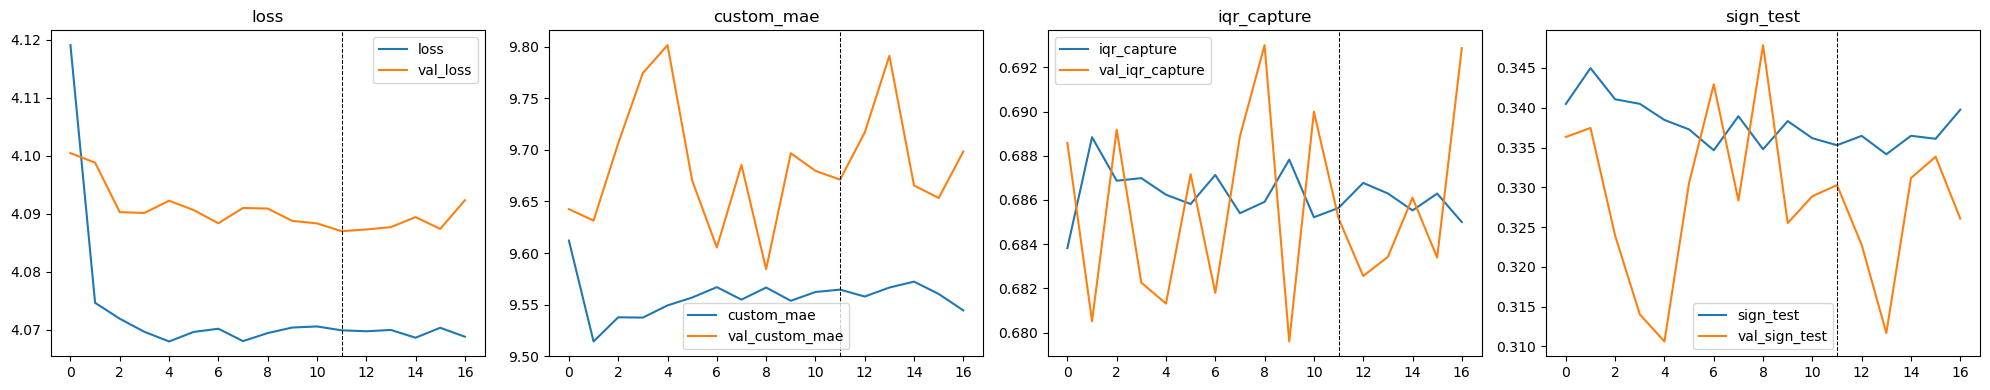

In [405]:
print(trainer.log.history.keys())

plt.figure(figsize=(20, 4))
for i, m in enumerate(("loss", *config["metrics"])):
    plt.subplot(1, 4, i + 1)
    plt.plot(trainer.log.history["epoch"], trainer.log.history[m], label=m)
    plt.plot(
        trainer.log.history["epoch"], trainer.log.history["val_" + m], label="val_" + m
    )
    plt.axvline(
       x=trainer.early_stopper.best_epoch, linestyle="--", color="k", linewidth=0.75
    )
    plt.title(m)
    plt.legend()
plt.tight_layout()
plt.show()